In [12]:
## Cell 1: Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

In [16]:
## Cell 2: Load Data and Create Connectivity Matrix
# Load data from the same path used in your existing script
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# Display first few rows to understand the structure
print("Dataset overview:")
print(fc_data.head())
print("\nColumns:", fc_data.columns.tolist())

# Check unique values for key columns
print("\nUnique seed hemispheres:", fc_data['seed_hemisphere'].unique())
print("Unique target hemispheres:", fc_data['target_hemisphere'].unique())
print("Unique seed ROIs:", fc_data['seed_roi'].unique())
print("Unique target ROIs:", fc_data['target_roi'].unique())

# Check specifically for PFs and aIPS data
print("\nChecking for PFs and aIPS data:")
pfs_data = fc_data[fc_data['seed_roi'] == 'PFs']
aips_data = fc_data[fc_data['seed_roi'] == 'aIPS']
print(f"Number of PFs data points: {len(pfs_data)}")
print(f"Number of aIPS data points: {len(aips_data)}")

# If we have data for these ROIs, let's see a sample
if len(pfs_data) > 0:
    print("\nSample PFs data:")
    print(pfs_data.head())
    
if len(aips_data) > 0:
    print("\nSample aIPS data:")
    print(aips_data.head())

# Let's also check for these regions as targets
pfs_target_data = fc_data[fc_data['target_roi'] == 'PFs']
aips_target_data = fc_data[fc_data['target_roi'] == 'aIPS']
print(f"\nNumber of PFs target data points: {len(pfs_target_data)}")
print(f"Number of aIPS target data points: {len(aips_target_data)}")

Dataset overview:
   subject seed_roi seed_hemisphere target_roi target_hemisphere task  \
0  sub-025     pIPS            left         LO              left  loc   
1  sub-025     pIPS            left         LO             right  loc   
2  sub-025     pIPS           right         LO              left  loc   
3  sub-025     pIPS           right         LO             right  loc   
8  sub-038     pIPS            left         LO              left  loc   

  analysis  mean_activation  
0       fc         0.176975  
1       fc         0.150175  
2       fc         0.171803  
3       fc         0.165211  
8       fc         0.202259  

Columns: ['subject', 'seed_roi', 'seed_hemisphere', 'target_roi', 'target_hemisphere', 'task', 'analysis', 'mean_activation']

Unique seed hemispheres: ['left' 'right']
Unique target hemispheres: ['left' 'right']
Unique seed ROIs: ['pIPS']
Unique target ROIs: ['LO']

Checking for PFs and aIPS data:
Number of PFs data points: 0
Number of aIPS data points: 0

Nu

In [14]:
## Cell 2: Load Data and Create Connectivity Matrix
# Load data from the same path used in your existing script
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# Display first few rows to understand the structure
print("Dataset overview:")
print(fc_data.head())
print("\nColumns:", fc_data.columns.tolist())

# Check unique values for key columns
print("\nUnique seed hemispheres:", fc_data['seed_hemisphere'].unique())
print("Unique target hemispheres:", fc_data['target_hemisphere'].unique())
print("Unique seed ROIs:", fc_data['seed_roi'].unique())
print("Unique target ROIs:", fc_data['target_roi'].unique())

Dataset overview:
   subject seed_roi seed_hemisphere target_roi target_hemisphere task  \
0  sub-025     pIPS            left         LO              left  loc   
1  sub-025     pIPS            left         LO             right  loc   
2  sub-025     pIPS           right         LO              left  loc   
3  sub-025     pIPS           right         LO             right  loc   
8  sub-038     pIPS            left         LO              left  loc   

  analysis  mean_activation  
0       fc         0.176975  
1       fc         0.150175  
2       fc         0.171803  
3       fc         0.165211  
8       fc         0.202259  

Columns: ['subject', 'seed_roi', 'seed_hemisphere', 'target_roi', 'target_hemisphere', 'task', 'analysis', 'mean_activation']

Unique seed hemispheres: ['left' 'right']
Unique target hemispheres: ['left' 'right']
Unique seed ROIs: ['pIPS']
Unique target ROIs: ['LO']


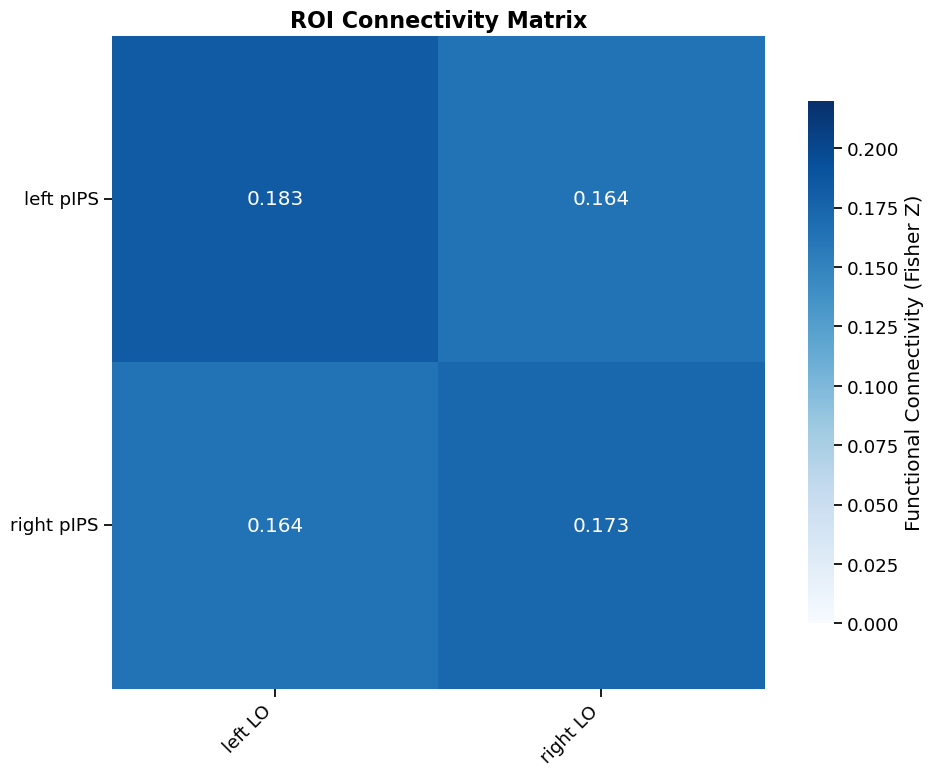

In [15]:
## Cell 3: Create a Connectivity Matrix
def create_connectivity_matrix(data):
    """
    Create a connectivity matrix from the FC data
    """
    # Set style parameters
    plt.style.use('default')
    sns.set_context("notebook", font_scale=1.2)
    
    # Extract unique seed and target regions/hemispheres
    seed_rois = data['seed_roi'].unique()
    target_rois = data['target_roi'].unique()
    hemispheres = ['left', 'right']
    
    # Create labels for matrix
    row_labels = [f"{hemi} {roi}" for roi in seed_rois for hemi in hemispheres]
    col_labels = [f"{hemi} {roi}" for roi in target_rois for hemi in hemispheres]
    
    # Initialize matrix with NaN values
    n_rows = len(row_labels)
    n_cols = len(col_labels)
    conn_matrix = np.full((n_rows, n_cols), np.nan)
    
    # Fill matrix with mean activation values
    for i, row_label in enumerate(row_labels):
        row_hemi, row_roi = row_label.split(' ', 1)
        for j, col_label in enumerate(col_labels):
            col_hemi, col_roi = col_label.split(' ', 1)
            
            # Filter data for this connection
            mask = (
                (data['seed_hemisphere'] == row_hemi) & 
                (data['seed_roi'] == row_roi) & 
                (data['target_hemisphere'] == col_hemi) & 
                (data['target_roi'] == col_roi)
            )
            
            if mask.any():
                conn_matrix[i, j] = data.loc[mask, 'mean_activation'].mean()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    # Using a blue color palette for better visualization of connectivity strengths
    cmap = sns.color_palette("Blues", as_cmap=True)
    mask = np.isnan(conn_matrix)
    
    sns.heatmap(
        conn_matrix, 
        mask=mask,
        cmap=cmap, 
        vmin=0, 
        vmax=0.22,  # Based on your original plot's y-limit
        square=True, 
        xticklabels=col_labels, 
        yticklabels=row_labels,
        cbar_kws={"shrink": .8, "label": "Functional Connectivity (Fisher Z)"},
        annot=True,   # Add numerical annotations
        fmt=".3f"     # Format with 3 decimal places
    )
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.title('ROI Connectivity Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig, conn_matrix

# Create and display connectivity matrix
matrix_fig, conn_matrix = create_connectivity_matrix(fc_data)
plt.show()
